# Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,plot_confusion_matrix)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
df = pd.read_csv('../datasets/modeling.csv', index_col=[0])

Feature Incorporation

In [3]:
#finding baseline. I increase the cutoff here and it resulted in better modeling
df.high_risk.value_counts(normalize=True)

1    0.607595
0    0.392405
Name: high_risk, dtype: float64

Train-Test Split and Scalling

In [4]:
df.columns

Index(['year', 'navarea_i', 'navarea_ii', 'navarea_iii', 'navarea_iv',
       'navarea_ix', 'navarea_v', 'navarea_vi', 'navarea_vii', 'navarea_viii',
       'navarea_x', 'navarea_xi', 'navarea_xii', 'navarea_xiii', 'navarea_xiv',
       'navarea_xv', 'navarea_xvi', 'poverty_percentage', 'attacks',
       'math_benchmark_percent', 'reading_benchmark_percent',
       'sea_law_adoption', 'R&D_proportion_of_GDP',
       'full_time_researchers_per_million', 'high_risk'],
      dtype='object')

In [5]:
sns_df = df.drop(['year', 'navarea_i', 'navarea_ii', 'navarea_iii', 'navarea_iv',
       'navarea_ix', 'navarea_v', 'navarea_vi', 'navarea_vii', 'navarea_viii',
       'navarea_x', 'navarea_xi', 'navarea_xii', 'navarea_xiii', 'navarea_xiv',
       'navarea_xv', 'navarea_xvi', 'attacks'], axis=1)
areas= df[['navarea_i', 'navarea_ii', 'navarea_iii', 'navarea_iv',
       'navarea_ix', 'navarea_v', 'navarea_vi', 'navarea_vii', 'navarea_viii',
       'navarea_x', 'navarea_xi', 'navarea_xii', 'navarea_xiii', 'navarea_xiv',
       'navarea_xv', 'navarea_xvi','high_risk']]

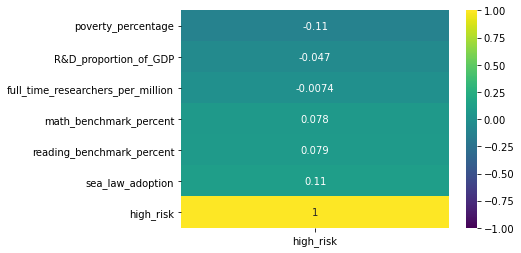

In [6]:
sns_plot = sns.heatmap(sns_df.corr()[['high_risk']].sort_values('high_risk'), 
           annot=True,
           cmap='viridis',
           vmin=-1,
           vmax=1)
plt.tight_layout
fig = sns_plot.get_figure()
fig.savefig('../img/feat_corr_map.png', bbox_inches="tight")

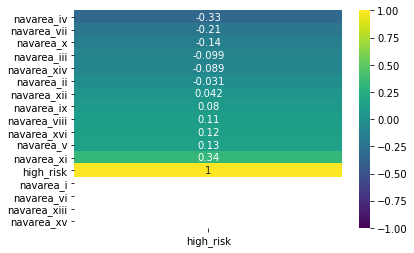

In [7]:
sns_plot = sns.heatmap(areas.corr()[['high_risk']].sort_values('high_risk'), 
           annot=True,
           cmap='viridis',
           vmin=-1,
           vmax=1)
plt.tight_layout
fig = sns_plot.get_figure()
fig.savefig('../img/nav_corr_map.png', bbox_inches="tight")

# Modeling

### Train Test Split

In [8]:
X = df.drop(['year','high_risk','attacks'], axis=1)
y = df.high_risk

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [9]:
X_train_sc.shape

(296, 22)

In [10]:
for col in X.columns.tolist():
    print(col, X[col].isna().sum())

navarea_i 0
navarea_ii 0
navarea_iii 0
navarea_iv 0
navarea_ix 0
navarea_v 0
navarea_vi 0
navarea_vii 0
navarea_viii 0
navarea_x 0
navarea_xi 0
navarea_xii 0
navarea_xiii 0
navarea_xiv 0
navarea_xv 0
navarea_xvi 0
poverty_percentage 0
math_benchmark_percent 0
reading_benchmark_percent 0
sea_law_adoption 0
R&D_proportion_of_GDP 0
full_time_researchers_per_million 0


### KNN

In [11]:
kn_params = {
    'n_neighbors': [3, 4, 7],
    'weights': ['uniform', 'distance'],
    'leaf_size': [5, 7, 10, 15, 30],
    'p': [1, 2],
    'n_jobs': [-1]}

In [12]:
grid_kn = GridSearchCV(KNeighborsClassifier(),
                  param_grid=kn_params)
grid_kn.fit(X_train_sc, y_train)
print(grid_kn.best_score_)
grid_kn.best_params_

0.9459322033898305


{'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

In [13]:
print(f'Score on training set: {grid_kn.score(X_train_sc, y_train)}')
print(f'Score on testing set: {grid_kn.score(X_test_sc, y_test)}')
scores = cross_val_score(grid_kn, 
                         X_train_sc, y_train,
                         cv = 10,
                         n_jobs=-1)

print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), 
                                 2 * scores.std()))

Score on training set: 0.9966216216216216
Score on testing set: 0.9797979797979798
Accuracy: 0.96 ± 0.04


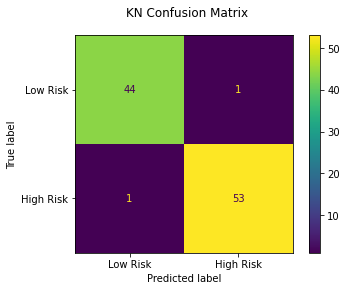

In [14]:
preds = grid_kn.predict(X_test)
disp = plot_confusion_matrix(grid_kn, X_test_sc, y_test, display_labels = ['Low Risk', 'High Risk'])
disp.figure_.suptitle("KN Confusion Matrix")
plt.savefig('../img/KN_Confusion_Matrix.png')
plt.show();

### Logistic Regression

In [15]:
lr_params = {
    'penalty': ['l1','l2'],
    'C': [1, .8],
    'solver': ['lbgs','sag','liblinear'],
    'max_iter': [80, 100, 200],
    'n_jobs': [-1]}

In [16]:
grid_lr = GridSearchCV(LogisticRegression(),
                  param_grid=lr_params)
grid_lr.fit(X_train_sc, y_train)
print(grid_lr.best_score_)
grid_lr.best_params_

0.7769491525423728


{'C': 1, 'max_iter': 80, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}

In [17]:
print(f'Score on training set: {grid_lr.score(X_train_sc, y_train)}')
print(f'Score on testing set: {grid_lr.score(X_test_sc, y_test)}')

Score on training set: 0.7837837837837838
Score on testing set: 0.7171717171717171


In [18]:
scores = cross_val_score(grid_lr, 
                         X_train_sc, y_train,
                         cv = 10,
                         n_jobs=-1)

print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), 
                                 2 * scores.std()))

Accuracy: 0.78 ± 0.10


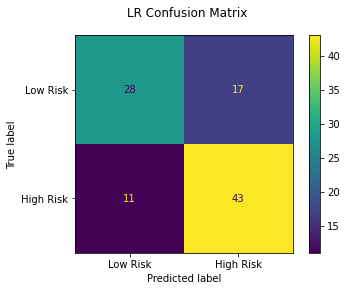

In [19]:
preds = grid_lr.predict(X_test)
disp = plot_confusion_matrix(grid_lr, X_test_sc, y_test, display_labels = ['Low Risk', 'High Risk'])
disp.figure_.suptitle("LR Confusion Matrix")
plt.savefig('../img/LR_Confusion_Matrix.png')
plt.show();

### Random Forrest

In [20]:
rf_params= {
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2,3],
    'min_samples_leaf' : [1,2],
    'max_samples' : [.7, .9],
    'ccp_alpha' : [0, .1],
    'n_jobs' : [-1]}

In [21]:
grid_rf = GridSearchCV(RandomForestClassifier(),
                  param_grid=rf_params)
grid_rf.fit(X_train_sc, y_train)
print(grid_rf.best_score_)
grid_rf.best_params_

0.9459887005649718


{'ccp_alpha': 0,
 'criterion': 'gini',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': -1}

In [22]:
print(f'Score on training set: {grid_rf.score(X_train_sc, y_train)}')
print(f'Score on testing set: {grid_rf.score(X_test_sc, y_test)}')

scores = cross_val_score(grid_rf, 
                         X_train_sc, y_train,
                         cv = 10,
                         n_jobs=-1)

print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), 
                                 2 * scores.std()))

Score on training set: 0.9966216216216216
Score on testing set: 0.9797979797979798
Accuracy: 0.96 ± 0.07


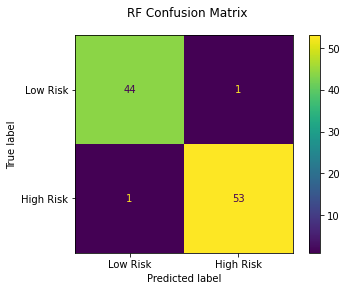

In [23]:
preds = grid_rf.predict(X_test)
disp = plot_confusion_matrix(grid_rf, X_test_sc, y_test, display_labels = ['Low Risk', 'High Risk'])
disp.figure_.suptitle("RF Confusion Matrix")
plt.savefig('../img/Rf_Confusion_Matrix.png')
plt.show();

### KNN without Nav Areas

In [24]:
X2 = sns_df.drop(['high_risk'], axis=1)
y2 = sns_df.high_risk

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=6)

ss = StandardScaler()
X2_train_sc = ss.fit_transform(X2_train)
X2_test_sc = ss.transform(X2_test)

In [25]:
kn2_params = {
    'n_neighbors': [3, 4, 7],
    'weights': ['uniform', 'distance'],
    'leaf_size': [5, 7, 10, 15, 30],
    'p': [1, 2],
    'n_jobs': [-1]}

In [26]:
grid_kn2 = GridSearchCV(KNeighborsClassifier(),
                  param_grid=kn2_params)
grid_kn2.fit(X2_train_sc, y2_train)
print(grid_kn2.best_score_)
grid_kn2.best_params_

0.9053107344632769


{'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

In [27]:
print(f'Score on training set: {grid_kn2.score(X2_train_sc, y2_train)}')
print(f'Score on testing set: {grid_kn2.score(X2_test_sc, y2_test)}')
scores = cross_val_score(grid_kn2, 
                         X2_train_sc, y2_train,
                         cv = 10,
                         n_jobs=-1)

print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), 
                                 2 * scores.std()))

Score on training set: 0.972972972972973
Score on testing set: 0.8484848484848485
Accuracy: 0.90 ± 0.09


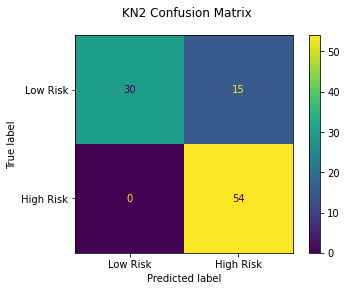

In [28]:
preds = grid_kn2.predict(X2_test)
disp = plot_confusion_matrix(grid_kn2, X2_test_sc, y2_test, display_labels = ['Low Risk', 'High Risk'])
disp.figure_.suptitle("KN2 Confusion Matrix")
plt.savefig('../img/KN2_Confusion_Matrix.png')
plt.show();

### Random forrest without Nav Areas

In [29]:
rf2_params= {
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2,3],
    'min_samples_leaf' : [1,2],
    'max_samples' : [.7, .9, .99],
    'ccp_alpha' : [0, .1],
    'n_jobs' : [-1]}

In [30]:
grid_rf2 = GridSearchCV(RandomForestClassifier(),
                  param_grid=rf2_params)
grid_rf2.fit(X2_train_sc, y2_train)
print(grid_rf2.best_score_)
grid_rf2.best_params_

0.9289830508474577


{'ccp_alpha': 0,
 'criterion': 'gini',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_jobs': -1}

In [31]:
print(f'Score on training set: {grid_rf2.score(X2_train_sc, y2_train)}')
print(f'Score on testing set: {grid_rf2.score(X2_test_sc, y2_test)}')

Score on training set: 0.972972972972973
Score on testing set: 0.8787878787878788


In [32]:
scores = cross_val_score(grid_rf2, 
                         X2_train_sc, y2_train,
                         cv = 10,
                        n_jobs=-1)

print('Accuracy: {:.2f} ± {:.2f}'.format(scores.mean(), 
                                 2 * scores.std()))

Accuracy: 0.93 ± 0.07


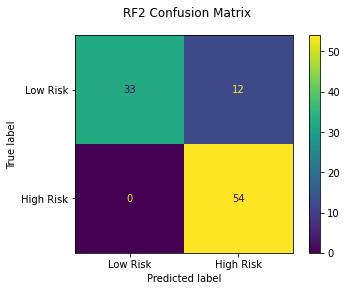

In [33]:
preds = grid_rf2.predict(X2_test)
disp = plot_confusion_matrix(grid_rf2, X2_test_sc, y2_test, display_labels = ['Low Risk', 'High Risk'])
disp.figure_.suptitle("RF2 Confusion Matrix")
plt.savefig('../img/RF2_Confusion_Matrix.png')
plt.show();